In [ ]:
import keras
keras.__version__

'2.15.0'

#**Переоценка и недооценка**
В этом блокноте собраны примеры кода из главы 3, раздела 6 книги «Глубокое обучение с помощью Python». Обратите внимание, что в оригинальном тексте содержится гораздо больше информации, в частности, дополнительные пояснения и рисунки: в этом блокноте вы найдете только исходный код и соответствующие комментарии.

---


Во всех примерах, которые мы рассматривали в предыдущей главе - предсказание настроения в рецензиях на фильмы, классификация тем и регрессия цен на жилье - мы могли заметить, что производительность нашей модели на удержанных проверочных данных всегда достигала пика через несколько эпох, а затем начинала ухудшаться, то есть наша модель быстро начинала перестраиваться под обучающие данные. Переоптимизация происходит в каждой задаче машинного обучения. Научиться справляться с избыточной подгонкой очень важно для освоения машинного обучения.

Фундаментальная проблема машинного обучения - это противоречие между оптимизацией и обобщением. Под «оптимизацией» понимается процесс настройки модели для достижения наилучшей производительности на обучающих данных («обучение» в слове «машинное обучение»), а под «обобщением» - то, насколько хорошо обученная модель будет работать на данных, которые она никогда раньше не видела. Конечно, цель игры - добиться хорошего обобщения, но вы не контролируете обобщение; вы можете только корректировать модель на основе ее обучающих данных.

В начале обучения оптимизация и обобщение коррелируют: чем меньше ваши потери на тренировочных данных, тем меньше ваши потери на тестовых данных. Пока это происходит, ваша модель считается недоукомплектованной: еще есть прогресс, сеть еще не смоделировала все релевантные паттерны в обучающих данных. Но после определенного количества итераций на обучающих данных обобщение перестает улучшаться, показатели валидации останавливаются, а затем начинают ухудшаться: модель начинает чрезмерно подходить, то есть она начинает изучать паттерны, характерные для обучающих данных, но вводящие в заблуждение или не имеющие отношения к новым данным.

Чтобы предотвратить обучение модели на ошибках или нерелевантных паттернах, найденных в обучающих данных, лучшим решением, конечно же, является получение большего количества обучающих данных. Модель, обученная на большем количестве данных, естественно, будет лучше обобщать. Когда это уже невозможно, следующим лучшим решением будет изменение количества информации, которую модели разрешено хранить, или добавление ограничений на то, какую информацию ей разрешено хранить. Если сеть может позволить себе запомнить только небольшое количество паттернов, процесс оптимизации заставит ее сосредоточиться на наиболее заметных паттернах, которые имеют больше шансов на хорошее обобщение.

Такая борьба с избыточным соответствием называется регуляризацией. Давайте рассмотрим некоторые из наиболее распространенных методов регуляризации и применим их на практике, чтобы улучшить нашу модель классификации фильмов из предыдущей главы.

Примечание: в этом блокноте мы будем использовать тестовый набор IMDB в качестве валидационного набора. В данном контексте это не имеет значения.

Давайте подготовим данные, используя код из главы 3, раздел 5:


In [ ]:
from keras.datasets import imdb
import numpy as np

(train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)

def vectorize_sequences(sequences, dimension=10000):
    # Создаем полностью нулевую матрицу формы (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        results[i, sequence] = 1.  # устанавливаем определенные индексы результатов[i] в 1s
    return results

# Наши векторизованные обучающие данные
x_train = vectorize_sequences(train_data)
# Наши векторизованные тестовые данные
x_test = vectorize_sequences(test_data)
# Наши векторизованные метки
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

#**Борьба с чрезмерной подгонкой**


##**Уменьшение размера сети**

Самый простой способ предотвратить перебор - уменьшить размер модели, то есть количество обучаемых параметров в модели (которое определяется количеством слоев и количеством блоков в слое). В глубоком обучении количество обучаемых параметров в модели часто называют «мощностью» модели. Интуитивно понятно, что модель с большим количеством параметров будет обладать большей «способностью к запоминанию» и, следовательно, сможет легко выучить идеальное словарное отображение между обучающими образцами и их целями - отображение без какой-либо обобщающей способности. Например, модель с 500 000 двоичных параметров можно легко заставить выучить класс каждой цифры в обучающем наборе MNIST: нам понадобится всего 10 двоичных параметров для каждой из 50 000 цифр. Такая модель будет бесполезна для классификации новых образцов цифр. Всегда помните об этом: модели глубокого обучения, как правило, хорошо подстраиваются под обучающие данные, но реальная задача заключается в обобщении, а не в подгонке.

С другой стороны, если сеть имеет ограниченные ресурсы запоминания, она не сможет выучить это отображение так же легко, и поэтому, чтобы минимизировать потери, ей придется прибегнуть к обучению сжатых представлений, которые обладают предсказательной силой в отношении целей - именно тот тип представлений, который нас интересует. В то же время не забывайте, что вы должны использовать модели с достаточным количеством параметров, чтобы они не были недоукомплектованы: ваша модель не должна испытывать недостатка в ресурсах для запоминания. Необходимо найти компромисс между «слишком большой емкостью» и «недостаточной емкостью».

К сожалению, не существует волшебной формулы, позволяющей определить нужное количество слоев или размер каждого из них. Вам придется оценить множество различных архитектур (разумеется, на валидационном, а не на тестовом множестве), чтобы найти правильный размер модели для ваших данных. Общий порядок действий для поиска подходящего размера модели заключается в том, чтобы начать с относительно небольшого количества слоев и параметров и увеличивать размер слоев или добавлять новые слои до тех пор, пока вы не увидите уменьшающуюся отдачу в отношении потерь при валидации.

Давайте попробуем это сделать на нашей сети классификации кинорецензий. Наша первоначальная сеть выглядела следующим образом:

In [ ]:
from keras import models
from keras import layers

original_model = models.Sequential()
original_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
original_model.add(layers.Dense(16, activation='relu'))
original_model.add(layers.Dense(1, activation='sigmoid'))

original_model.compile(optimizer='rmsprop',
                       loss='binary_crossentropy',
                       metrics=['acc'])

Теперь попробуем заменить ее на эту меньшую сеть:

In [ ]:
smaller_model = models.Sequential()
smaller_model.add(layers.Dense(4, activation='relu', input_shape=(10000,)))
smaller_model.add(layers.Dense(4, activation='relu'))
smaller_model.add(layers.Dense(1, activation='sigmoid'))

smaller_model.compile(optimizer='rmsprop',
                      loss='binary_crossentropy',
                      metrics=['acc'])

Вот сравнение потерь при валидации исходной сети и сети меньшего размера. Точки - это значения потерь при валидации меньшей сети, а крестики - исходной сети (помните: меньшие потери при валидации свидетельствуют о лучшей модели).

In [ ]:
original_hist = original_model.fit(x_train, y_train,
                                   epochs=20,
                                   batch_size=512,
                                   validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 109ms/step - loss: 0.4884 - acc: 0.8042 - val_loss: 0.3567 - val_acc: 0.8768
Epoch 2/20
49/49 [==============================] - 2s 38ms/step - loss: 0.2859 - acc: 0.9003 - val_loss: 0.2934 - val_acc: 0.8853
Epoch 3/20
49/49 [==============================] - 3s 52ms/step - loss: 0.2202 - acc: 0.9214 - val_loss: 0.2783 - val_acc: 0.8894
Epoch 4/20
49/49 [==============================] - 3s 52ms/step - loss: 0.1851 - acc: 0.9337 - val_loss: 0.2855 - val_acc: 0.8861
Epoch 5/20
49/49 [==============================] - 2s 37ms/step - loss: 0.1620 - acc: 0.9418 - val_loss: 0.3008 - val_acc: 0.8814
Epoch 6/20
49/49 [==============================] - 3s 58ms/step - loss: 0.1433 - acc: 0.9500 - val_loss: 0.3351 - val_acc: 0.8719
Epoch 7/20
49/49 [==============================] - 2s 41ms/step - loss: 0.1292 - acc: 0.9541 - val_loss: 0.3270 - val_acc: 0.8778
Epoch 8/20
49/49 [==============================] - 3s 52ms/step - loss: 0.1167 - 

In [ ]:
smaller_model_hist = smaller_model.fit(x_train, y_train,
                                       epochs=20,
                                       batch_size=512,
                                       validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - 6s 114ms/step - loss: 0.6265 - acc: 0.6754 - val_loss: 0.5748 - val_acc: 0.7465
Epoch 2/20
49/49 [==============================] - 3s 55ms/step - loss: 0.5072 - acc: 0.8408 - val_loss: 0.4660 - val_acc: 0.8526
Epoch 3/20
49/49 [==============================] - 2s 36ms/step - loss: 0.3821 - acc: 0.8936 - val_loss: 0.3602 - val_acc: 0.8823
Epoch 4/20
49/49 [==============================] - 2s 36ms/step - loss: 0.2880 - acc: 0.9119 - val_loss: 0.3081 - val_acc: 0.8870
Epoch 5/20
49/49 [==============================] - 2s 36ms/step - loss: 0.2370 - acc: 0.9217 - val_loss: 0.2856 - val_acc: 0.8885
Epoch 6/20
49/49 [==============================] - 2s 36ms/step - loss: 0.2069 - acc: 0.9281 - val_loss: 0.2782 - val_acc: 0.8902
Epoch 7/20
49/49 [==============================] - 2s 42ms/step - loss: 0.1864 - acc: 0.9362 - val_loss: 0.2826 - val_acc: 0.8845
Epoch 8/20
49/49 [==============================] - 3s 61ms/step - loss: 0.1705 - 

In [ ]:
epochs = range(1, 21)
original_val_loss = original_hist.history['val_loss']
smaller_model_val_loss = smaller_model_hist.history['val_loss']

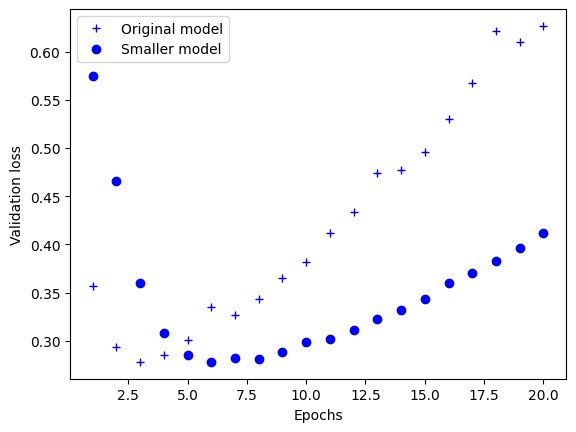

In [ ]:
import matplotlib.pyplot as plt

# b+ означает «синий крест»
plt.plot(epochs, original_val_loss, 'b+', label='Original model')
# «bo» означает «синяя точка»
plt.plot(epochs, smaller_model_val_loss, 'bo', label='Smaller model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Как мы видим, меньшая сеть начинает перестраиваться позже, чем эталонная (после 6 эпох, а не 4), и ее производительность снижается гораздо медленнее, как только она начинает перестраиваться.

А теперь, ради интереса, добавим к этому эталону сеть, которая имеет гораздо большую емкость, гораздо большую, чем того требует задача:

In [ ]:
bigger_model = models.Sequential()
bigger_model.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
bigger_model.add(layers.Dense(512, activation='relu'))
bigger_model.add(layers.Dense(1, activation='sigmoid'))

bigger_model.compile(optimizer='rmsprop',
                     loss='binary_crossentropy',
                     metrics=['acc'])

In [ ]:
bigger_model_hist = bigger_model.fit(x_train, y_train,
                                     epochs=20,
                                     batch_size=512,
                                     validation_data=(x_test, y_test))

Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 0.4929 - acc: 0.7634

Вот как выглядит большая сеть по сравнению с эталонной. Точки - это значения потерь при проверке большей сети, а крестики - исходной сети.

In [ ]:
bigger_model_val_loss = bigger_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_val_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Более крупная сеть начинает перестраиваться почти сразу же, после одной эпохи, и перестраивается гораздо сильнее. Ее потери при проверке также более шумные.

А вот потери при обучении для двух наших сетей:

In [ ]:
original_train_loss = original_hist.history['loss']
bigger_model_train_loss = bigger_model_hist.history['loss']

plt.plot(epochs, original_train_loss, 'b+', label='Original model')
plt.plot(epochs, bigger_model_train_loss, 'bo', label='Bigger model')
plt.xlabel('Epochs')
plt.ylabel('Training loss')
plt.legend()

plt.show()

Как видите, более крупная сеть очень быстро приближает потери при обучении к нулю. Чем больше мощность сети, тем быстрее она сможет смоделировать обучающие данные (что приводит к низким потерям при обучении), но тем больше она подвержена перестройке (что приводит к большой разнице между потерями при обучении и проверке).

#**Добавление весовой регуляризации**

Возможно, вы знакомы с принципом «бритвы Оккама»: при наличии двух объяснений чего-либо наиболее вероятным правильным будет «простейшее» объяснение, то есть то, которое делает наименьшее количество предположений. Это относится и к моделям, обучаемым нейронными сетями: при наличии обучающих данных и архитектуры сети существует несколько наборов значений весов (несколько моделей), которые могут объяснить данные, и более простые модели менее склонны к перестройке, чем сложные.

Простая модель» в данном контексте - это модель, в которой распределение значений параметров имеет меньшую энтропию (или модель с меньшим количеством параметров, как мы видели в разделе выше). Таким образом, распространенным способом борьбы с избыточной подгонкой является наложение ограничений на сложность сети путем принуждения ее весов принимать только малые значения, что делает распределение значений весов более «регулярным». Это называется «регуляризацией весов», и делается она путем добавления к функции потерь сети стоимости, связанной с наличием больших весов. Эта стоимость бывает двух видов:

- Регуляризация L1, при которой добавленная стоимость пропорциональна абсолютному значению весовых коэффициентов (т.е. тому, что называется «нормой L1» весов).
- Регуляризация L2, при которой добавленная стоимость пропорциональна квадрату значения весовых коэффициентов (т.е. тому, что называется «нормой L2» весов). В контексте нейронных сетей L2-регуляризация также называется затуханием веса. Пусть вас не смущает другое название: с математической точки зрения затухание веса - это то же самое, что и L2-регуляризация.

В Keras весовая регуляризация добавляется путем передачи экземпляров весового регуляризатора слоям в качестве аргументов ключевых слов. Давайте добавим весовую регуляризацию L2 в нашу сеть классификации рецензий на фильмы:

In [ ]:
from keras import regularizers

l2_model = models.Sequential()
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu', input_shape=(10000,)))
l2_model.add(layers.Dense(16, kernel_regularizer=regularizers.l2(0.001),
                          activation='relu'))
l2_model.add(layers.Dense(1, activation='sigmoid'))

In [ ]:
l2_model.compile(optimizer='rmsprop',
                 loss='binary_crossentropy',
                 metrics=['acc'])

l2(0.001) означает, что каждый коэффициент в матрице весов слоя будет добавлять 0.001 * вес_коэффициента_значения к общему убытку сети. Обратите внимание, что поскольку этот штраф добавляется только во время обучения, потери для этой сети будут гораздо выше во время обучения, чем во время тестирования.
Вот влияние нашего штрафа регуляризации L2

In [ ]:
l2_model_hist = l2_model.fit(x_train, y_train,
                             epochs=20,
                             batch_size=512,
                             validation_data=(x_test, y_test))

Epoch 1/20
48/49 [============================>.] - ETA: 0s - loss: 0.5504 - acc: 0.7908

In [ ]:
l2_model_val_loss = l2_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, l2_model_val_loss, 'bo', label='L2-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

Как видите, модель с регуляризацией L2 (точки) стала гораздо более устойчивой к переборке, чем эталонная модель (крестики), хотя обе модели имеют одинаковое количество параметров.

В качестве альтернативы регуляризации L2 можно использовать один из следующих весовых регуляризаторов Keras:

In [ ]:
from keras import regularizers

# L1 regularization
regularizers.l1(0.001)

# L1 and L2 regularization at the same time
regularizers.l1_l2(l1=0.001, l2=0.001)

#**Добавление dropout**

Dropout - один из самых эффективных и наиболее часто используемых методов регуляризации для нейронных сетей, разработанный Хинтоном и его студентами в Университете Торонто. Dropout, применяемый к слою, заключается в случайном «выпадении» (т. е. установке нуля) ряда выходных признаков слоя в процессе обучения. Допустим, данный слой в процессе обучения обычно возвращал вектор [0.2, 0.5, 1.3, 0.8, 1.1] для заданного входного образца; после применения отсева этот вектор будет содержать несколько нулевых записей, распределенных случайным образом, например [0, 0.5, 1.3, 0, 1.1]. Коэффициент отсева» - это доля признаков, которые обнуляются; обычно он устанавливается в диапазоне от 0,2 до 0,5. В момент тестирования никакие единицы не отбрасываются, а вместо этого выходные значения слоя уменьшаются на коэффициент, равный коэффициенту отсева, чтобы сбалансировать тот факт, что активными являются больше единиц, чем в момент обучения.

Рассмотрим матрицу Numpy, содержащую выход слоя, layer_output , формы (batch_size, features). Во время обучения мы будем случайным образом обнулять часть значений в матрице:

In [ ]:
# Во время обучения: мы отбрасываем 50% единиц на выходе
layer_output *= np.randint(0, high=2, size=layer_output.shape)

Во время тестирования мы уменьшим результат на коэффициент dropout. Здесь мы масштабируем на 0,5 (потому что ранее мы отсеяли половину единиц):

In [ ]:
# Во время тестирования:
layer_output *= 0.5

Обратите внимание, что этот процесс можно реализовать, выполнив обе операции во время обучения и оставив выход неизменным во время тестирования, что часто и происходит на практике:

In [ ]:
# Во время обучения:
layer_output *= np.randint(0, high=2, size=layer_output.shape)
# Обратите внимание, что в данном случае мы масштабируем *вверх*, а не *вниз*.
layer_output /= 0.5

Эта техника может показаться странной и произвольной. Почему это должно помочь уменьшить избыточную подгонку? Джефф Хинтон сказал, что его вдохновил, среди прочего, механизм предотвращения мошенничества, используемый банками - по его собственным словам: «Я пошел в свой банк. Кассиры постоянно менялись, и я спросил одного из них, почему. Он ответил, что не знает, но их часто переставляют с места на место. Я решил, что это, должно быть, потому, что для успешного обмана банка требуется сотрудничество между сотрудниками. Это заставило меня понять, что случайное удаление различных подмножеств нейронов в каждом примере позволит избежать сговора и, таким образом, уменьшить перебор».

Основная идея заключается в том, что введение шума в выходные значения слоя может разрушить случайные паттерны, которые не являются значимыми (то, что Хинтон называет «заговорами»), и которые сеть начала бы запоминать, если бы шум не присутствовал.

В Keras вы можете ввести отсев в сеть с помощью слоя Dropout, который применяется к выходу слоя, расположенного непосредственно перед ним, например:

In [ ]:
model.add(layers.Dropout(0.5))

Давайте добавим два слоя Dropout в нашу сеть IMDB, чтобы посмотреть, насколько хорошо они справляются с задачей уменьшения избыточной подгонки:

In [ ]:
dpt_model = models.Sequential()
dpt_model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(16, activation='relu'))
dpt_model.add(layers.Dropout(0.5))
dpt_model.add(layers.Dense(1, activation='sigmoid'))

dpt_model.compile(optimizer='rmsprop',
                  loss='binary_crossentropy',
                  metrics=['acc'])

In [ ]:
dpt_model_hist = dpt_model.fit(x_train, y_train,
                               epochs=20,
                               batch_size=512,
                               validation_data=(x_test, y_test))

Построим график результатов:

In [ ]:
dpt_model_val_loss = dpt_model_hist.history['val_loss']

plt.plot(epochs, original_val_loss, 'b+', label='Original model')
plt.plot(epochs, dpt_model_val_loss, 'bo', label='Dropout-regularized model')
plt.xlabel('Epochs')
plt.ylabel('Validation loss')
plt.legend()

plt.show()

И снова явное улучшение по сравнению с эталонной сетью.

Подведем итог: вот наиболее распространенные способы предотвращения оверфиттинга в нейронных сетях:
- Получение большего количества обучающих данных.
- Уменьшение пропускной способности сети.
- Добавление регуляризации веса.
- Добавление dropout.